# Related movies recommendation system

## 1. Prepare data for training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [2]:
scores = pd.read_csv('data/genome_scores.csv')
movie = pd.read_csv('data/movie.csv')
rating = pd.read_csv('data/rating.csv')

In [3]:
scores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [4]:
mean_relevance = scores[['movieId', 'relevance']].groupby('movieId').mean().reset_index()
mean_relevance.head()

,movieId,relevance
0,1,0.160223
1,2,0.119486
2,3,0.092403
3,4,0.085427
4,5,0.098853


In [5]:
movie_rating = pd.read_csv('movie_rating.csv')

In [6]:
movie_rating.head()

,Unnamed: 0,movieId,rating,title,genres,num ratings
0,0,1,3.921240,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,49695
1,1,2,3.211977,Jumanji (1995),Adventure|Children|Fantasy,22243
2,2,3,3.151040,Grumpier Old Men (1995),Comedy|Romance,12735
3,3,4,2.861393,Waiting to Exhale (1995),Comedy|Drama|Romance,2756
4,4,5,3.064592,Father of the Bride Part II (1995),Comedy,12161


In [7]:
df = movie_rating.merge(mean_relevance, on = 'movieId')[['movieId', 'rating', 'title', 'genres', 'relevance']]
df.head()

,movieId,rating,title,genres,relevance
0,1,3.921240,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.160223
1,2,3.211977,Jumanji (1995),Adventure|Children|Fantasy,0.119486
2,3,3.151040,Grumpier Old Men (1995),Comedy|Romance,0.092403
3,4,2.861393,Waiting to Exhale (1995),Comedy|Drama|Romance,0.085427
4,5,3.064592,Father of the Bride Part II (1995),Comedy,0.098853


In [8]:
df_copy = df.copy()
for i in range(len(df_copy['genres'])):
    if '|' in df_copy['genres'][i]:
        df_copy.drop(index = i, inplace = True)

In [9]:
df_copy

,movieId,rating,title,genres,relevance
4,5,3.064592,Father of the Bride Part II (1995),Comedy,0.098853
8,9,3.004924,Sudden Death (1995),Action,0.076288
13,14,3.432082,Nixon (1995),Drama,0.126963
17,18,3.373631,Four Rooms (1995),Comedy,0.127113
18,19,2.607412,Ace Ventura: When Nature Calls (1995),Comedy,0.109521
...,...,...,...,...,...
10354,129737,2.500000,Unfinished Business (2015),Comedy,0.103683
10356,129781,4.500000,About Alex (2014),Drama,0.051083
10367,131013,2.500000,Get Hard (2015),Comedy,0.097136
10368,131168,3.500000,Phoenix (2014),Drama,0.136695


In [10]:
for i in range(len(df)):
    if '|' in df.loc[i]['genres']:
        list_genre = df.loc[i]['genres'].split('|')
        list_rating = []
        list_movieId = []
        list_title = []
        list_relevance = []
        for i in range(len(list_genre)):
            list_rating.append(df.loc[i]['rating'])
            list_movieId.append(df.loc[i]['movieId'])
            list_title.append(df.loc[i]['title'])
            list_relevance.append(df.loc[i]['relevance'])
        dict = {'movieId' : list_movieId, 'rating': list_rating , 'title' : list_title, 'genres' : list_genre, 'relevance': list_relevance}
        df0 = pd.DataFrame(dict)
        df_copy = pd.concat([df_copy, df0], ignore_index = True)   

In [11]:
df_copy['genres'].value_counts()

genres
Drama                 5032
Comedy                3736
Thriller              2010
Romance               1752
Action                1720
Crime                 1250
Adventure             1176
Horror                1025
Sci-Fi                 909
Fantasy                695
Children               620
Mystery                615
Documentary            466
Animation              458
War                    440
Musical                401
Western                219
IMAX                   164
Film-Noir              112
(no genres listed)       1
Name: count, dtype: int64

In [12]:
df_copy = df_copy[df_copy['genres'] != '(no genres listed)']
df_copy['genres'].value_counts()

genres
Drama          5032
Comedy         3736
Thriller       2010
Romance        1752
Action         1720
Crime          1250
Adventure      1176
Horror         1025
Sci-Fi          909
Fantasy         695
Children        620
Mystery         615
Documentary     466
Animation       458
War             440
Musical         401
Western         219
IMAX            164
Film-Noir       112
Name: count, dtype: int64

In [13]:
df_copy

,movieId,rating,title,genres,relevance
0,5,3.064592,Father of the Bride Part II (1995),Comedy,0.098853
1,9,3.004924,Sudden Death (1995),Action,0.076288
2,14,3.432082,Nixon (1995),Drama,0.126963
3,18,3.373631,Four Rooms (1995),Comedy,0.127113
4,19,2.607412,Ace Ventura: When Nature Calls (1995),Comedy,0.109521
...,...,...,...,...,...
22796,1,3.921240,Toy Story (1995),Action,0.160223
22797,2,3.211977,Jumanji (1995),Thriller,0.119486
22798,1,3.921240,Toy Story (1995),Horror,0.160223
22799,2,3.211977,Jumanji (1995),Romance,0.119486


## 2. Training K-Mean model

In [14]:
mapper = {'Drama' : 0, 'Comedy' : 1, 'Thriller' : 2, 'Romance' : 3, 'Action' : 4, 'Crime' : 5,
         'Adventure' : 6, 'Horror' : 7, 'Sci-Fi' : 8, 'Fantasy' : 9, 'Children' : 10, 'Mystery' : 11,
         'Documentary' : 12, 'Animation': 13, 'War' : 14, 'Musical' : 15, 'Western' : 16, 'IMAX' : 17,
         'Film-Noir' : 18}
# df_copy['genres'] = df['genres'].map(mapper)

In [15]:
df_copy

,movieId,rating,title,genres,relevance
0,5,3.064592,Father of the Bride Part II (1995),Comedy,0.098853
1,9,3.004924,Sudden Death (1995),Action,0.076288
2,14,3.432082,Nixon (1995),Drama,0.126963
3,18,3.373631,Four Rooms (1995),Comedy,0.127113
4,19,2.607412,Ace Ventura: When Nature Calls (1995),Comedy,0.109521
...,...,...,...,...,...
22796,1,3.921240,Toy Story (1995),Action,0.160223
22797,2,3.211977,Jumanji (1995),Thriller,0.119486
22798,1,3.921240,Toy Story (1995),Horror,0.160223
22799,2,3.211977,Jumanji (1995),Romance,0.119486


In [16]:
df_copy['genres'] = df_copy['genres'].str.strip().map(mapper)

In [17]:
df_copy.head()

,movieId,rating,title,genres,relevance
0,5,3.064592,Father of the Bride Part II (1995),1,0.098853
1,9,3.004924,Sudden Death (1995),4,0.076288
2,14,3.432082,Nixon (1995),0,0.126963
3,18,3.373631,Four Rooms (1995),1,0.127113
4,19,2.607412,Ace Ventura: When Nature Calls (1995),1,0.109521


In [18]:
df_np = df_copy[['rating', 'genres', 'relevance']].to_numpy()
df_np

array([[3.06459173, 1.        , 0.09885306],
       [3.00492424, 4.        , 0.07628834],
       [3.43208236, 0.        , 0.12696321],
       ...,
       [3.92123956, 7.        , 0.16022252],
       [3.2119768 , 3.        , 0.11948604],
       [3.15104044, 8.        , 0.09240337]])

In [19]:
k_mean_8 = KMeans(n_clusters = 8)
k_mean_8.fit(df_np)
label_8 = k_mean_8.labels_

In [20]:
label_8

array([0, 3, 7, ..., 2, 5, 2])

In [21]:
silhouette_score_8 = metrics.silhouette_score(df_np, label_8, metric='euclidean')
calinski_harabasz_score_8 = metrics.calinski_harabasz_score(df_np, label_8)
print('Silhouette_score of 8 clusters : ', silhouette_score_8)
print('Calinski_harabasz_score of 8 clusters', calinski_harabasz_score_8)

Silhouette_score of 8 clusters :  0.5821282178723116
Calinski_harabasz_score of 8 clusters 148564.361979747


In [22]:
k_mean_16 = KMeans(n_clusters = 16)
k_mean_16.fit(df_np)
label_16 = k_mean_16.labels_

In [23]:
silhouette_score_16 = metrics.silhouette_score(df_np, label_16, metric='euclidean')
calinski_harabasz_score_16 = metrics.calinski_harabasz_score(df_np, label_16)
print('Silhouette_score of 16 clusters : ', silhouette_score_16)
print('Calinski_harabasz_score of 16 clusters', calinski_harabasz_score_16)

Silhouette_score of 16 clusters :  0.758245399589098
Calinski_harabasz_score of 16 clusters 279829.9843759126


In [24]:
sum_distance = []
silhouette_score = []
calinski_harabasz_score = []
K = range(2,15)
for i in K:
    k_mean_K = KMeans(n_clusters = i)
    k_mean_K.fit(df_np)
    label_K = k_mean_K.labels_
    sum_distance.append(k_mean_K.inertia_)
    silhouette_score.append(metrics.silhouette_score(df_np, label_K, metric='euclidean'))
    calinski_harabasz_score.append(metrics.calinski_harabasz_score(df_np, label_K))


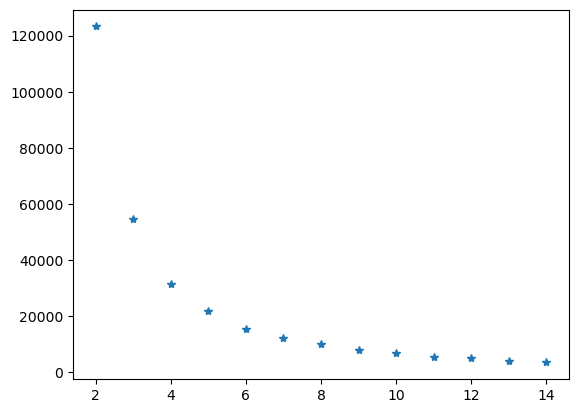

In [25]:
plt.plot(K, sum_distance, '*')

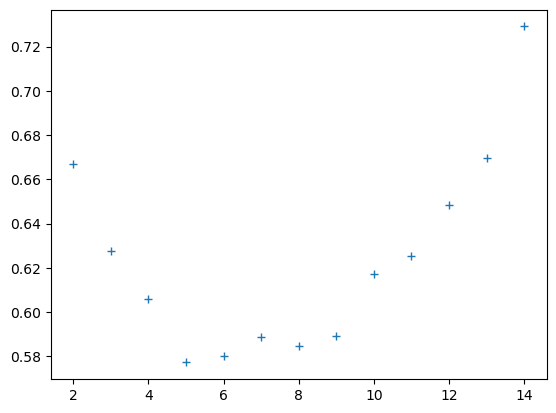

In [26]:
plt.plot(K, silhouette_score, '+')

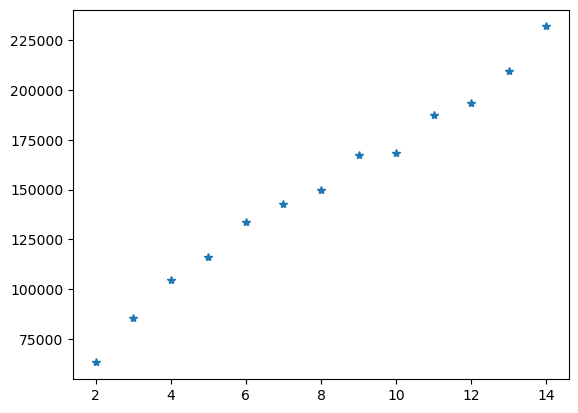

In [27]:
plt.plot(K, calinski_harabasz_score, '*')

In [28]:
k_mean_7 = KMeans(n_clusters = 7)
model = k_mean_7.fit(df_np)
result = k_mean_7.labels_

In [29]:
silhouette_score_7 = metrics.silhouette_score(df_np, result, metric='euclidean')
calinski_harabasz_score_7 = metrics.calinski_harabasz_score(df_np, result)
print('Silhouette_score of 16 clusters : ', silhouette_score_7)
print('Calinski_harabasz_score of 16 clusters', calinski_harabasz_score_7)

Silhouette_score of 16 clusters :  0.58579276808728
Calinski_harabasz_score of 16 clusters 141953.79964621208


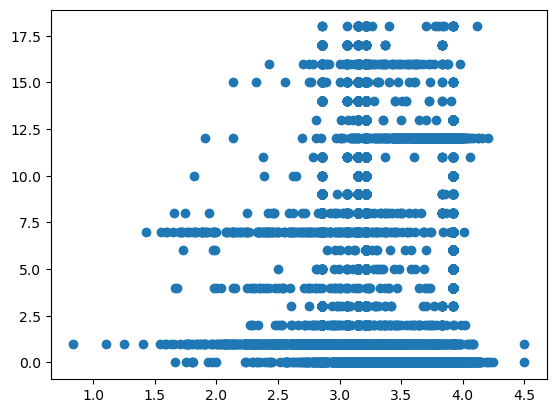

In [30]:
plt.scatter(df_np[:,0], df_np[:,1])
plt.show()

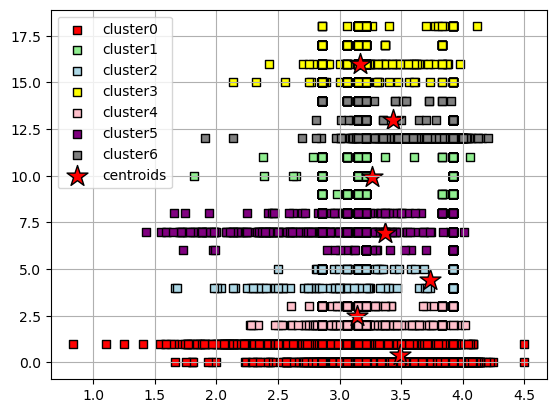

In [31]:
color = ['red', 'lightgreen', 'lightblue', 'yellow', 'pink', 'purple', 'grey']
for i in range(7):
    plt.scatter(
    df_np[result == i, 0], df_np[result == i, 1],
    c= color[i],
    marker='s', edgecolor='black',
    label='cluster' + str(i)
)
    
    
plt.scatter(
    model.cluster_centers_[:, 0], model.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)


plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [32]:
df_copy['cluster'] = result

## 3. Recommend top 5 related movies

In [129]:
def recommend_id_movie(movie):
#     df_recommend = df_copy[df_copy['cluster'] == int(df_copy[df_copy['title'] == movie]['cluster'])]
    most_popular_cluster = pd.DataFrame(df_copy[df_copy['title'] == movie]['cluster'].value_counts()).reset_index()['cluster'][0]
    df_recommend = df_copy[df_copy['cluster'] == most_popular_cluster]
    df_info_movie = df_copy[df_copy['title'] == movie]
    df_info_movie = df_info_movie[df_info_movie['cluster'] == most_popular_cluster].reset_index().iloc[0]
    df_recommend['distance'] = np.sqrt((df_recommend['rating']-float(df_info_movie['rating']))**2 + 
                                       (df_recommend['genres'] - float(df_info_movie['genres']))**2 + 
                                       (df_recommend['relevance'] - float(df_info_movie['relevance']))**2)
    df_recommend = df_recommend[['movieId', 'distance']].groupby('movieId').mean().reset_index()
    df_recommend.sort_values(by = 'distance', inplace = True)
#     df_recommend = df_recommend[df_recommend['distance'] != 0]
    df_recommend = df_recommend.head(5)
    recommend_id = list(df_recommend['movieId'])
    return recommend_id

In [132]:
def give_inf_movie(ids):
    list_df_movie = []
    for id in ids:
        list_df_movie.append(df[df['movieId'] == id])
    movies = list_df_movie[0]
    
    for i in range(1, 5):
        movies = pd.concat([movies, list_df_movie[i]], ignore_index = True)
    return movies

In [134]:
movie = input('Enter the movie you interested in : ')
print('Top 5 movies you might like to watch :')
give_inf_movie(recommend_id_movie(movie))

Enter the movie you interested in : Toy Story (1995)
Top 5 movies you might like to watch :


,movieId,rating,title,genres,relevance
0,6104,3.923753,Monty Python Live at the Hollywood Bowl (1982),Comedy,0.172473
1,3507,3.906070,"Odd Couple, The (1968)",Comedy,0.147124
2,2300,3.918047,"Producers, The (1968)",Comedy,0.138374
3,1449,3.942756,Waiting for Guffman (1996),Comedy,0.146539
4,2918,3.943668,Ferris Bueller's Day Off (1986),Comedy,0.175459
